In [1]:
!pip install tensorflow
!pip install umap-learn
!pip install squarify

%matplotlib inline

import os
import pprint
import json
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy as sc
from scipy.stats import gaussian_kde
import seaborn as sns
import squarify

import tensorflow as tf
import sklearn as sk
import sklearn.neural_network
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

/Users/tomas/Projects/tfg/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data_dir = "data"
data = {}
if os.path.exists(data_dir) and os.path.isdir(data_dir):
    filenames = [entry.name for entry in os.scandir(data_dir) if not entry.name.startswith(".")]

    for filename in filenames:
        name = filename[:-4]
        path = os.path.join(data_dir, filename)
        df = (
            pd.read_csv(path)
            if filename.endswith(".csv")
            else pd.read_csv(path, sep="\t", low_memory=False)
        )
        data[name] = {
            "name": name,
            "filename": filename,
            "path": path,
            "df": df,
        }
else:
    print(f"The directory '{data_dir}' does not exist or is not a directory.")

In [3]:
df_names = data["names"]["df"].copy()
df_classification = data["classification"]["df"].copy()
df_consolidated_cell_types = data["consolidated_cell_types"]["df"].copy()
df_visual_neuron_types = data["visual_neuron_types"]["df"].copy()

df_cell_stats = data["cell_stats"]["df"].copy()
df_neurons = data["neurons"]["df"].copy()

df_coordinates = data["coordinates"]["df"].copy()

df_connections = data["connections"]["df"].copy()
df_connectivity_tags = data["connectivity_tags"]["df"].copy()
df_neuropil_synapse_table = data["neuropil_synapse_table"]["df"].copy()

In [4]:
rows = []
for item in list(data.values()):
    df_name = item["name"]
    df = item["df"]
    rows.append(f"Dataset: {df_name}")
    rows.append(f"Shape: {df.shape}")
    rows.append(f"Fields:")
    for col in item["df"].columns:
        unique_values = df[col].unique()
        len_unique_values = len(unique_values)
        field_text = (
            f"- {col} > missing count: {df[col].isnull().sum()}; unique count: {len_unique_values}"
        )
        if len_unique_values <= 20:
            field_text += f"; unique values: [{', '.join(str(v) for v in unique_values)}]"
        else:
            field_text += f"; some values: [{', '.join(str(v) for v in unique_values[:5])}]"
        rows.append(field_text)
    rows.append("\n")

for row in rows:
    print(row)

Dataset: labels
Shape: (160026, 9)
Fields:
- root_id > missing count: 0; unique count: 110033; some values: [720575940620306785, 720575940607848203, 720575940630087542, 720575940629102636, 720575940615200059]
- label > missing count: 0; unique count: 7566; some values: [putative fru, aIP1c, aIP1c, put_AVL08ob, aSP8a, aSP8, aSP8a, put_ADL01hB]
- user_id > missing count: 0; unique count: 153; some values: [22, 2356, 17, 1012, 392]
- position > missing count: 0; unique count: 138624; some values: [[356596 169884 102760], [381456 181024  80800], [317436 143972 154440], [335516 158120 157800], [319724 153508 168080]]
- supervoxel_id > missing count: 0; unique count: 137654; some values: [76774705348089545, 77197123904568079, 76070605790736921, 76352286926320589, 76141112041072926]
- label_id > missing count: 0; unique count: 160026; some values: [1, 2, 3, 4, 5]
- date_created > missing count: 0; unique count: 52137; some values: [2022-02-07 04:55:09, 2022-02-07 04:55:10, 2022-12-02 18:02:37

In [5]:
import pandas as pd

summary_rows = []
for item in list(data.values()):
    df_name = item["name"]
    df = item["df"]

    for col in df.columns:
        if "synapses in" in col or "partners in" in col:
            continue
        missing_count = df[col].isnull().sum()
        unique_values = df[col].unique()
        len_unique_values = len(unique_values)

        if len_unique_values <= 20:
            example_values = ", ".join(str(v) for v in unique_values)
        else:
            example_values = ", ".join(str(v) for v in unique_values[:5]) + ", ..."

        summary_rows.append(
            {
                "Dataset Name": df_name,
                "Field": col,
                "Missing Count": missing_count,
                "Unique Count": len_unique_values,
                "Example/Unique Values": example_values,
            }
        )

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("summary_df.csv")

print(f"Datasets: {len(data.keys())}")
display(summary_df)

Datasets: 16


,Dataset Name,Field,Missing Count,Unique Count,Example/Unique Values
0,labels,root_id,0,110033,"720575940620306785, 720575940607848203, 720575..."
1,labels,label,0,7566,"putative fru, aIP1c, aIP1c, put_AVL08ob, aSP8a..."
2,labels,user_id,0,153,"22, 2356, 17, 1012, 392, ..."
3,labels,position,0,138624,"[356596 169884 102760], [381456 181024 80800]..."
4,labels,supervoxel_id,0,137654,"76774705348089545, 77197123904568079, 76070605..."
...,...,...,...,...,...
80,cell_stats,area_nm,0,138763,"628299136, 1634424448, 1022307072, 2346787840,..."
81,cell_stats,size_nm,0,138632,"37616302080, 100004290560, 58954229760, 140744..."
82,consolidated_cell_types,root_id,0,137680,"720575940596125868, 720575940597856265, 720575..."
83,consolidated_cell_types,primary_type,0,8549,"T5c, Tm16, Tm7, TmY15, Tm1, ..."


In [6]:
data.keys()

dict_keys(['labels', 'processed_labels', 'connectivity_tags', 'neuropil_synapse_table', 'visual_neuron_types', 'connections_no_threshold', 'coordinates', 'connections', 'names', 'neurons', 'classification', 'synapse_coordinates', 'synapse_attachment_rates', 'column_assignment', 'cell_stats', 'consolidated_cell_types'])

In [7]:
key = "consolidated_cell_types"
print(data[key]["df"].shape)
display(data[key]["df"].head())

key = "classification"
print(data[key]["df"].shape)
display(data[key]["df"].head())

key = "visual_neuron_types"
print(data[key]["df"].shape)
display(data[key]["df"].head())

(137680, 3)


,root_id,primary_type,additional_type(s)
0,720575940596125868,T5c,NaN
1,720575940597856265,Tm16,NaN
2,720575940597944841,Tm7,CB3851
3,720575940598267657,TmY15,NaN
4,720575940599333574,Tm1,NaN


(139255, 10)


,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
0,720575940640144768,intrinsic,optic,NaN,L1-5,L1,NaN,NaN,right,NaN
1,720575940630759755,intrinsic,central,NaN,NaN,CB1092,NaN,LB3,left,NaN
2,720575940637932009,intrinsic,central,Kenyon_Cell,NaN,NaN,KCg-m,MBp3,left,NaN
3,720575940606131116,intrinsic,optic,NaN,NaN,Tlp4,NaN,NaN,left,NaN
4,720575940633723091,intrinsic,optic,NaN,NaN,Tm4,NaN,NaN,left,NaN


(95157, 6)


,root_id,type,family,subsystem,category,side
0,720575940596125868,T5c,T5 Neuron,Motion,intrinsic,right
1,720575940597856265,Tm16,Transmedullary,Color,intrinsic,right
2,720575940597944841,Tm7,Transmedullary,Color,intrinsic,right
3,720575940598267657,TmY15,Transmedullary Y,Object,intrinsic,right
4,720575940599333574,Tm1,Transmedullary,OFF,intrinsic,right


In [8]:
# get what dataset to use as main one to begin merge
# should have less than 140k records as the fruit fly brain does not have more neurons
# we just want to check the closes value

max_df_name = ""
max_df_count = 0
for df_name in data.keys():
    c = data[df_name]["df"].shape[0]
    if c == max_df_count:
        print(f"{df_name} same with {c}")
    if c > max_df_count and c < 140000:
        max_df_name = df_name
        max_df_count = c
print(max_df_name, max_df_count)

neurons same with 139255
classification same with 139255
names 139255


# Groups

**Skipped**
- column_assignment: Only right optic lobe availabe.
- processed_labels: Both processed and original labels contain too much noise in the strings.

**Classification and hierarchy**
- consolidated_cell_types (root_id, primary_type)
- classification (root_id, flow, super_class, cell_type, side)
- names (root_id, names, group) (names: group+id, so check if group makes sense)
- visual_neuron_types (root_id, type, family, subsystem, category, side)


**Cell morphology and neurotransmitters**
- cell_stats (root_id, length_nm, area_nm, size_nm)
- neurons (root_id, group, nt_type, nt_type_score) (group maybe is the same as names.group)

**Coordinates (both neurons and connections)**
- coordinates (root_id, position) (position is an array with x,y,z)

**Connections**
- connections (pre_root_id, post_root_id, neuropil, syn_count, nt_type)
- connectivity_tags (root_id, connectivity_tag) (connectivity tag is a concatenated string)
- neuropil_synapse_table (root_id, input_synapses, input_partners, output_synapses, output_partners)

In [28]:
# The classification we are going to use:

# consolidated_cell_types > (137k) primary_type
# classification          > (139k) super_class, class, sub_class, cell_type, hemibrain_type, hemilineage, side, nerve, flow
# visual_neuron_types     >  (95k) type, family, subsystem, category, side

# Main df: classification <> consolidated_cell_types <> visual_neuron_types


# d1_cols = ["primary_type"]
# d2_cols = [
#     f"{x}_celltype"
#     for x in [
#         "super_class",
#         "class",
#         "sub_class",
#         "cell_type",
#         "hemibrain_type",
#         "hemilineage",
#         "side",
#         "nerve",
#         "flow",
#     ]
# ]
# d3_cols = [f"{x}_visualtype" for x in ["type", "family", "subsystem", "category", "side"]]
d1_cols = ["primary_type"]
d2_cols = [
    "super_class",
    "class",
    "sub_class",
    "cell_type",
    "hemibrain_type",
    "hemilineage",
    "side",
    "nerve",
    "flow",
]
d3_cols = ["type", "family", "subsystem", "category", "side_visualtype"]
cols = d1_cols + d2_cols + d3_cols

df_class = pd.merge(
    df_classification,
    df_consolidated_cell_types,
    on="root_id",
    how="left",
    indicator="consolidated_cell_types",
    suffixes=("", "_celltype"),
)

df_class = pd.merge(
    df_class,
    df_visual_neuron_types,
    on="root_id",
    how="left",
    indicator="visual_neuron_types",
    suffixes=("", "_visualtype"),
)

# print(df_class.shape)
# display(df_class.head())
# print([x for x in df_class.columns if x.endswith("_celltype") or x.endswith("_visualtype")])

df_class["side"] = df_class["side"].astype(str)

df_class[["root_id", "primary_type", "cell_type", "hemibrain_type", "type"]].to_csv(
    "classification.csv"
)

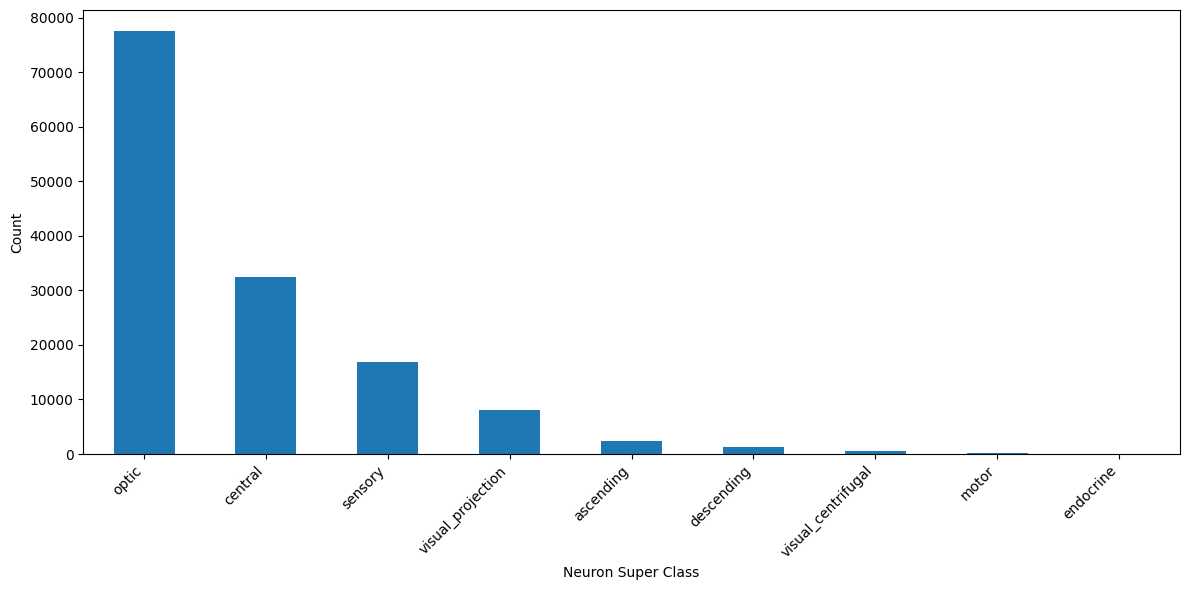

In [55]:
plt.figure(figsize=(12, 6))
df_class["super_class"].value_counts().plot(kind="bar")
plt.xlabel("Neuron Super Class")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Primary Type Summary Statistics:
Total Records: 137680
Unique Categories: 8549
Top Category: R1-6
Top Category Count: 8525
Mean Count: 16.1048075798339
Median Count: 2.0
Min Count: 1
Max Count: 8525
Categories with Single Occurrence: 54
Top N Covered Percent: 28.66


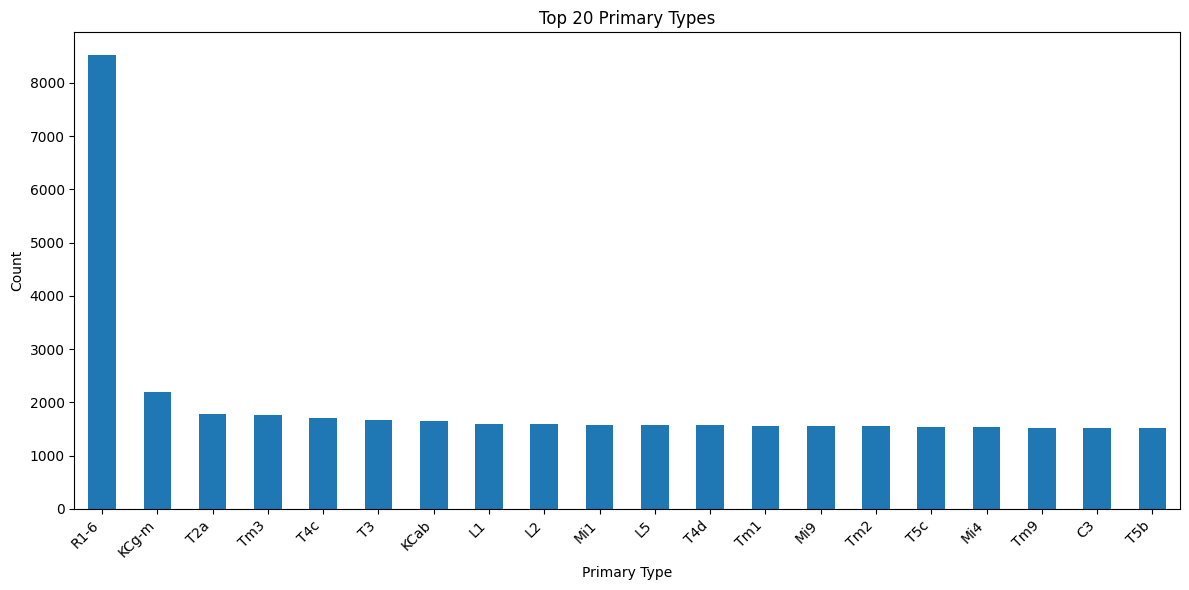

Number of primary types required to explain each % of the data:
Top types for 50%: 44 types
Top types for 75%: 245 types
Top types for 80%: 506 types
Top types for 90%: 2706 types
Top types for 95%: 5080 types
Top types for 99%: 7834 types


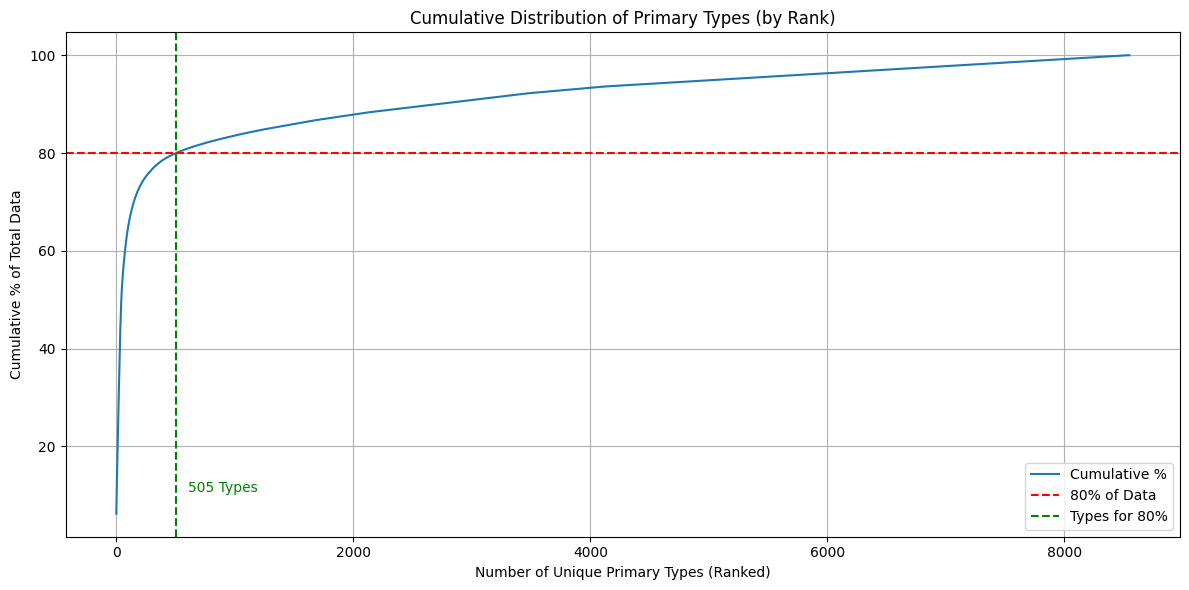

Types with count < mean (16.10): 8086 types
That's 94.58% of all unique neuron types


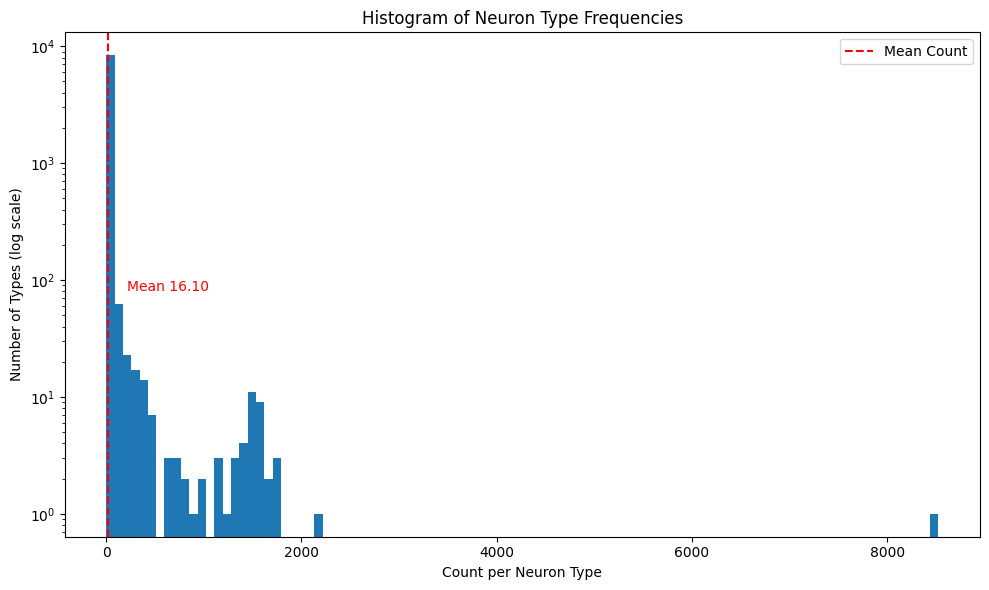

Types with count < mean (16.10): 8086 types
That's 94.6% of all unique neuron types


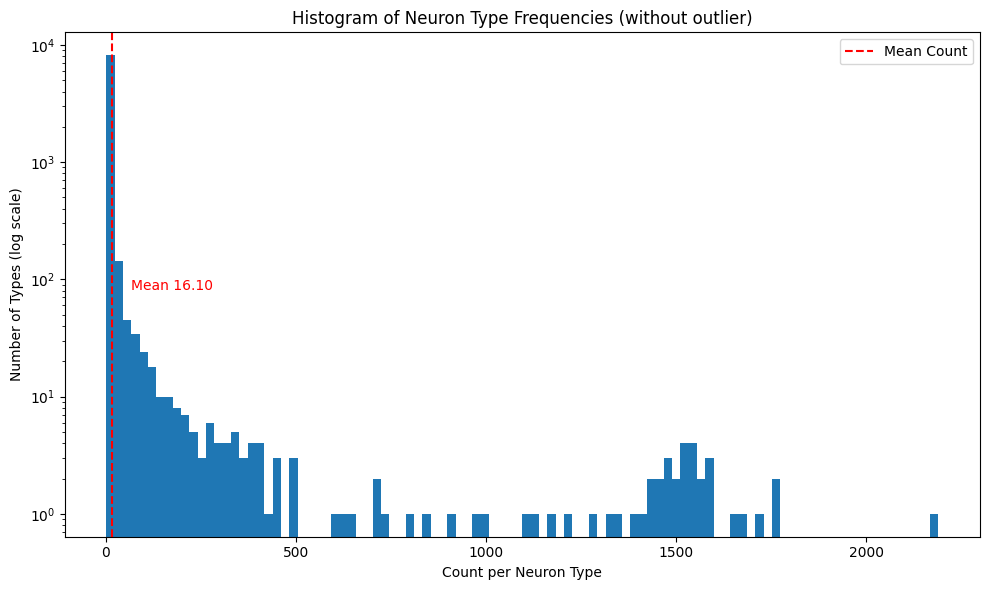

In [26]:
value_counts = df_class["primary_type"].value_counts()

# Set N for top categories
N = 20
top_types = value_counts.head(N)
other_count = value_counts[N:].sum()

# Combine top N and aggregate "OTHER"
# aggregated = pd.concat([top_types, pd.Series({"OTHER": other_count})])
aggregated = top_types

# Summary statistics
stats = {
    "Total Records": value_counts.sum(),
    "Unique Categories": value_counts.size,
    "Top Category": top_types.idxmax(),
    "Top Category Count": top_types.max(),
    "Mean Count": value_counts.mean(),
    "Median Count": value_counts.median(),
    "Min Count": value_counts.min(),
    "Max Count": value_counts.max(),
    "Categories with Single Occurrence": (value_counts == 1).sum(),
    "Top N Covered Percent": round((top_types.sum() / value_counts.sum()) * 100, 2),
}

# Print stats
print("Primary Type Summary Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

# Bar Plot of Top N
plt.figure(figsize=(12, 6))
aggregated.plot(kind="bar")
plt.title(f"Top {N} Primary Types")
plt.xlabel("Primary Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Compute cumulative sum and percentage
cumulative = value_counts.cumsum()
cumulative_pct = cumulative / cumulative.iloc[-1] * 100

# Find how many types explain various % thresholds
thresholds = [50, 75, 80, 90, 95, 99]
explain_count = {f"Top types for {t}%": (cumulative_pct < t).sum() + 1 for t in thresholds}

# Print explanation
print("Number of primary types required to explain each % of the data:")
for k, v in explain_count.items():
    print(f"{k}: {v} types")

# Compute cumulative sum and percentage
cumulative = value_counts.cumsum()
cumulative_pct = cumulative / cumulative.iloc[-1] * 100

# Find how many types explain various % thresholds
thresholds = [50, 75, 80, 90, 95, 99]
explain_count = {f"Top types for {t}%": (cumulative_pct < t).sum() + 1 for t in thresholds}

# Calculate x-value for 80% threshold
x_80 = (cumulative_pct < 80).sum()

plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_pct)), cumulative_pct.values, label="Cumulative %")

plt.axhline(y=80, color="red", linestyle="--", label="80% of Data")
plt.axvline(x=x_80, color="green", linestyle="--", label="Types for 80%")

# Add annotation for the green line
plt.text(x_80 + 100, 10, f"{x_80} Types", color="green", va="bottom", ha="left")

plt.title("Cumulative Distribution of Primary Types (by Rank)")
plt.xlabel("Number of Unique Primary Types (Ranked)")
plt.ylabel("Cumulative % of Total Data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##

value_counts = df_class["primary_type"].value_counts()
mean_count = value_counts.mean()

# Number and proportion of types below mean
below_mean_count = (value_counts < mean_count).sum()
below_mean_percent = round((below_mean_count / len(value_counts)) * 100, 2)

print(f"Types with count < mean ({mean_count:.2f}): {below_mean_count} types")
print(f"That's {below_mean_percent}% of all unique neuron types")

plt.figure(figsize=(10, 6))
plt.hist(value_counts, bins=100, log=True)
plt.axvline(mean_count, color="red", linestyle="--", label="Mean Count")
plt.text(mean_count + 200, 100, f"Mean {mean_count:.2f}", color="red", va="top", ha="left")
plt.title("Histogram of Neuron Type Frequencies")
plt.xlabel("Count per Neuron Type")
plt.ylabel("Number of Types (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

## Same plot but without the outlier
# value_counts = [x for x in value_counts if x < value_counts.max()]
value_counts = [x for x in value_counts if x < 2500]
below_mean_count = (value_counts < mean_count).sum()
below_mean_percent = round((below_mean_count / len(value_counts)) * 100, 2)

print(f"Types with count < mean ({mean_count:.2f}): {below_mean_count} types")
print(f"That's {below_mean_percent}% of all unique neuron types")

plt.figure(figsize=(10, 6))
plt.hist(value_counts, bins=100, log=True)
plt.axvline(mean_count, color="red", linestyle="--", label="Mean Count")
plt.text(mean_count + 50, 100, f"Mean {mean_count:.2f}", color="red", va="top", ha="left")
plt.title("Histogram of Neuron Type Frequencies (without outlier)")
plt.xlabel("Count per Neuron Type")
plt.ylabel("Number of Types (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
## ------------------------------------------------------------------------------
# check: classification.flow == visual_neuron_types.category
# insights: they are different
########
df_class.loc[df_class["type"].notnull()]["super_class"].unique()
output: [
    "optic",
    "visual_projection",
    "sensory",
    "visual_centrifugal",
    "central",
    "descending",
    "ascending",
]

df_class.loc[(df_class["type"].notnull())]["flow"].unique()
output: ["intrinsic", "afferent", "efferent"]
df_class["category"].unique()
output: ["intrinsic", "boundary"]

print(df_class.loc[df_class["category"] == "intrinsic"]["flow"].unique())
output: ["intrinsic" "afferent"]
print(df_class.loc[df_class["category"] == "boundary"]["flow"].unique())
output: ["intrinsic" "efferent" "afferent"]

['intrinsic' 'afferent']
['intrinsic' 'efferent' 'afferent']


In [12]:
## ------------------------------------------------------------------------------
# check: classification.side == visual_neuron_types.side (.side_visualtype)
# insights: yes
########

## ------------------------------------------------------------------------------
# check do we need: classification.. hemilineage, nerve, flow
# insights: Keep flow
#           Drop hemilineage (74%) and nerve (93%). Too many missing values.
########

cls = ["hemilineage", "nerve", "flow"]
l = df_class.shape[0]
for c in cls:
    ms = df_class[c].isnull().sum()
    print(f"- {c}: {ms} missing ({round(ms/l*100, 2)}%)")

- hemilineage: 102358 missing (73.5%)
- nerve: 129616 missing (93.08%)
- flow: 0 missing (0.0%)


In [13]:
## ------------------------------------------------------------------------------
# check nulls/proportions: classification.. super_class, class, sub_class, cell_type
# check do we need: visual_neuron_types.. family, subsystem, category
########

cls = ["super_class", "class", "sub_class", "family", "subsystem"]
l = df_class.shape[0]
for c in cls:
    ms = df_class[c].isnull().sum()
    uv = df_class[c].unique()
    print(f"- {c}: {ms} missing ({round(ms/l*100, 2)}%) {uv[:5]}")


print(df_class["class"].unique())
print(df_class["sub_class"].unique())
print(df_class["subsystem"].unique())
print(df_class["super_class"].unique())

## super_class, family (31% missing), subsystem (37% missing)
## class, sub_class 80% missing

- super_class: 0 missing (0.0%) ['optic' 'central' 'descending' 'visual_projection' 'sensory']
- class: 109192 missing (78.41%) [nan 'Kenyon_Cell' 'visual' 'AN' 'mechanosensory']
- sub_class: 119124 missing (85.54%) ['L1-5' nan 'columnar' 'AN_GNG' 'eye_bristle']
- family: 44138 missing (31.7%) ['Lamina Monopolar' nan 'Translobula Plate' 'Transmedullary' 'Y Neuron']
- subsystem: 52542 missing (37.73%) ['ON' nan 'Motion' 'OFF' 'Object']
[nan 'Kenyon_Cell' 'visual' 'AN' 'mechanosensory' 'unknown_sensory' 'LHLN'
 'olfactory' 'CX' 'DAN' 'gustatory' 'ALPN' 'MBON' 'hygrosensory'
 'bilateral' 'ALLN' 'ALON' 'LHCENT' 'ALIN' 'TuBu' 'thermosensory' 'mAL'
 'ocellar' 'pars_intercerebralis' 'pars_lateralis' 'optic_lobes' 'TPN'
 'MBIN']
['L1-5' nan 'columnar' 'AN_GNG' 'eye_bristle'
 'pharyngeal_nerve_sensory_group2' 'ocellar' 'SA_DMT_DMetaN' 'sugar/water'
 'multiglomerular' 'auditory' 'tangential' 'uniglomerular' 'ring_neuron'
 'low-salt' 'AN_GNG_IPS' 'head_bristle' 'SA_DMT_ADMN' 'AN_GNG_AMMC'
 'AN_AV

In [42]:
df_class["super_class"].value_counts()

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

In [14]:
df_connections.columns

Index(['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type'], dtype='object')

In [31]:
# QUESTION? Is the dominant neuron neurotransmitter correlated with the number of synpases??
# INFO: neurons.group = <neuropil.input>.<neuropil.output> or <neuropil>

# df_neurons_nt = df_neurons[["root_id", "nt_type", "nt_type_score"]].copy()
df_neurons_nt = df_neurons.copy()
df_neurons_nt.dropna(inplace=True)
print(f"Shape original: {df_neurons.shape}")
print(f"Shape: {df_neurons_nt.shape}")


def custom_func(group):
    group = group[["pre_root_id", "nt_type", "syn_count"]]

    summary = group.groupby("nt_type")["syn_count"].sum().sort_values(ascending=False)
    summary_list = list(summary.items())
    total = summary.sum()

    # Main NT and its ratio
    if summary_list:
        main_nt, main_count = summary_list[0]
        main_ratio = main_count / total
    else:
        main_nt, main_ratio = None, None

    # One-hot encode ratios
    ratio_dict = {nt: float(count / total) for nt, count in summary_list}

    # Combine everything into a single row dict
    result = {
        "root_id": group["pre_root_id"].iloc[0],
        "nt_summary": summary_list,
        "nt_by_syn": main_nt,
        "nt_ratio_by_syn": main_ratio,
    }

    result.update(ratio_dict)

    return pd.DataFrame([result])


nt_grps = df_connections.groupby("pre_root_id", group_keys=False)[
    ["pre_root_id", "nt_type", "syn_count"]
].apply(custom_func)

df_neurons_nt = df_neurons_nt.merge(nt_grps)
print(f"Merge shape: {df_neurons_nt.shape}")

Shape original: (139255, 10)
Shape: (119597, 10)
Merge shape: (119597, 19)


In [32]:
# Check if synapse count = dominant nt
diff_main_nt = df_neurons_nt[df_neurons_nt["nt_type"] != df_neurons_nt["nt_by_syn"]]["nt_type"]
print(f"diff main nt: {diff_main_nt.shape[0]}")
diff_main_nt.value_counts()

diff main nt: 389


nt_type
ACH     208
GLUT    106
GABA     47
SER      25
DA        2
OCT       1
Name: count, dtype: int64

In [33]:
print(f"All neurons with synapsis info: {df_neurons_nt.shape[0]}")
print(
    f'Neurons with nt_ratio_by_syn less than 80%: {df_neurons_nt[(df_neurons_nt["nt_ratio_by_syn"] < 0.80)].shape[0]}'
)

All neurons with synapsis info: 119597
Neurons with nt_ratio_by_syn less than 80%: 8808


In [34]:
df_neurons_nt[
    (df_neurons_nt["nt_type_score"] < 0.80)
    & (df_neurons_nt["nt_summary"].apply(lambda x: len(x) > 1))
][
    [
        "nt_type",
        "nt_type_score",
        "da_avg",
        "ser_avg",
        "gaba_avg",
        "glut_avg",
        "ach_avg",
        "oct_avg",
        "ACH",
        "GLUT",
        "GABA",
        "OCT",
        "DA",
        "SER",
    ]
]

,nt_type,nt_type_score,da_avg,ser_avg,gaba_avg,glut_avg,ach_avg,oct_avg,ACH,GLUT,GABA,OCT,DA,SER
0,ACH,0.57,0.03,0.00,0.05,0.28,0.57,0.07,0.948980,0.051020,NaN,NaN,NaN,NaN
12,ACH,0.70,0.06,0.01,0.04,0.15,0.70,0.04,0.986842,NaN,0.013158,NaN,NaN,NaN
15,ACH,0.54,0.04,0.02,0.08,0.21,0.54,0.12,0.956250,0.043750,NaN,NaN,NaN,NaN
17,ACH,0.51,0.03,0.00,0.11,0.31,0.51,0.04,0.733333,0.266667,NaN,NaN,NaN,NaN
18,ACH,0.58,0.05,0.01,0.10,0.20,0.58,0.07,0.958333,NaN,NaN,0.041667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119581,GLUT,0.63,0.02,0.01,0.25,0.63,0.08,0.01,NaN,0.960573,0.039427,NaN,NaN,NaN
119585,ACH,0.48,0.16,0.05,0.04,0.21,0.48,0.05,0.848485,0.060606,NaN,NaN,0.090909,NaN
119590,GLUT,0.52,0.00,0.00,0.41,0.52,0.06,0.00,NaN,0.706294,0.293706,NaN,NaN,NaN
119594,GABA,0.71,0.00,0.00,0.71,0.17,0.11,0.00,NaN,0.005525,0.994475,NaN,NaN,NaN


In [35]:
# PRE_SYN ANALYSIS

df_neurons_nt = df_neurons.copy()
df_neurons_nt.dropna(inplace=True)
print(f"Shape original: {df_neurons.shape}")
print(f"Shape: {df_neurons_nt.shape}")


def custom_func(group):
    group = group[["post_root_id", "nt_type", "syn_count"]]

    summary = group.groupby("nt_type")["syn_count"].sum().sort_values(ascending=False)
    summary_list = list(summary.items())
    total = summary.sum()

    # Main NT and its ratio
    if summary_list:
        main_nt, main_count = summary_list[0]
        main_ratio = main_count / total
    else:
        main_nt, main_ratio = None, None

    # One-hot encode ratios
    ratio_dict = {nt: float(count / total) for nt, count in summary_list}

    # Combine everything into a single row dict
    result = {
        "root_id": group["post_root_id"].iloc[0],
        "nt_summary": summary_list,
        "nt_by_syn": main_nt,
        "nt_ratio_by_syn": main_ratio,
    }

    result.update(ratio_dict)

    return pd.DataFrame([result])


nt_grps = df_connections.groupby("post_root_id", group_keys=False)[
    ["post_root_id", "nt_type", "syn_count"]
].apply(custom_func)

df_neurons_nt = df_neurons_nt.merge(nt_grps)
print(f"Merge shape: {df_neurons_nt.shape}")
print(f"All neurons with synapsis info: {df_neurons_nt.shape[0]}")
print(
    f'Neurons with nt_ratio_by_syn less than 80%: {df_neurons_nt[(df_neurons_nt["nt_ratio_by_syn"] < 0.80)].shape[0]}'
)

Shape original: (139255, 10)
Shape: (119597, 10)
Merge shape: (112474, 19)
All neurons with synapsis info: 112474
Neurons with nt_ratio_by_syn less than 80%: 93197


In [36]:
counter = {}
for x in df_neurons_nt["nt_summary"]:
    l = len(x)
    if l in counter:
        counter[l] += 1
    else:
        counter[l] = 1
counter

{3: 57539, 2: 28468, 1: 8065, 4: 12604, 5: 4634, 6: 1164}

In [37]:
from collections import Counter

# Extract sorted neurotransmitter combinations (ignoring counts)
combos = [tuple(sorted(nt for nt, _ in entry)) for entry in df_neurons_nt["nt_summary"]]

# Count how often each combination appears
combo_counter = Counter(combos)
combo_counter

Counter({('ACH', 'GABA', 'GLUT'): 53716,
         ('ACH', 'GABA'): 20660,
         ('ACH', 'GLUT'): 5462,
         ('ACH', 'DA', 'GABA', 'GLUT'): 4856,
         ('ACH', 'GABA', 'GLUT', 'OCT'): 4411,
         ('ACH',): 3956,
         ('ACH', 'DA', 'GABA', 'GLUT', 'SER'): 3253,
         ('GABA',): 3021,
         ('ACH', 'GABA', 'GLUT', 'SER'): 2849,
         ('ACH', 'DA', 'GABA'): 1722,
         ('GABA', 'GLUT'): 1715,
         ('ACH', 'DA', 'GABA', 'GLUT', 'OCT', 'SER'): 1164,
         ('ACH', 'DA', 'GABA', 'GLUT', 'OCT'): 1064,
         ('GLUT',): 957,
         ('ACH', 'GABA', 'OCT'): 690,
         ('ACH', 'GABA', 'SER'): 453,
         ('ACH', 'GLUT', 'SER'): 409,
         ('ACH', 'GABA', 'GLUT', 'OCT', 'SER'): 293,
         ('ACH', 'DA', 'GLUT'): 278,
         ('ACH', 'DA', 'GABA', 'SER'): 259,
         ('GABA', 'SER'): 216,
         ('ACH', 'DA', 'GLUT', 'SER'): 146,
         ('ACH', 'SER'): 126,
         ('ACH', 'GLUT', 'OCT'): 116,
         ('DA', 'GABA'): 105,
         ('SER',): 9

In [38]:
print(df_neurons_nt)

                   root_id      group nt_type  nt_type_score  da_avg  ser_avg  \
0       720575940596125868     LO.LOP     ACH           0.57    0.03     0.00   
1       720575940597856265         ME     ACH           0.85    0.01     0.00   
2       720575940597944841      ME.LO     ACH           0.82    0.02     0.00   
3       720575940598267657         ME    GABA           0.74    0.01     0.01   
4       720575940599333574         ME     ACH           0.61    0.02     0.00   
...                    ...        ...     ...            ...     ...      ...   
112469  720575940661327745     LO.SCL     ACH           0.83    0.08     0.00   
112470  720575940661329281       AVLP     ACH           0.85    0.08     0.01   
112471  720575940661335681        GNG    GABA           0.71    0.00     0.00   
112472  720575940661336193      ME.LO     ACH           0.62    0.02     0.00   
112473  720575940661337217  SCL.MB_ML     ACH           1.00    0.00     0.00   

        gaba_avg  glut_avg 

---

In [39]:
## Fixing previous analysis
##

pivot_counts = df_connections.pivot_table(
    index=["pre_root_id", "post_root_id"],
    columns="nt_type",
    values="syn_count",
    fill_value=0,
    aggfunc="sum",  # This is safe since each (pre, post, nt_type) should be unique
).reset_index()


nt_columns = [col for col in pivot_counts.columns if col not in ["pre_root_id", "post_root_id"]]
pivot_counts["total_synapses"] = pivot_counts[nt_columns].sum(axis=1)
pivot_counts["dominant_nt"] = pivot_counts[nt_columns].idxmax(axis=1)
pivot_counts["dominant_nt_count"] = pivot_counts[nt_columns].max(axis=1)
pivot_counts["dominant_nt_pct"] = (
    pivot_counts["dominant_nt_count"] / pivot_counts["total_synapses"] * 100
).round(2)
pivot_counts

pivot_counts.loc[pivot_counts["dominant_nt_pct"] < 100]

nt_type,pre_root_id,post_root_id,ACH,DA,GABA,GLUT,OCT,SER,total_synapses,dominant_nt,dominant_nt_count,dominant_nt_pct
38,720575940597856265,720575940627150110,7,0,0,1,0,0,8,ACH,7,87.50
201,720575940599763910,720575940628307026,12,0,1,0,0,0,13,ACH,12,92.31
235,720575940600101641,720575940619298373,2,0,0,9,0,0,11,GLUT,9,81.82
256,720575940600143369,720575940610593860,4,0,0,4,0,0,8,ACH,4,50.00
340,720575940600646173,720575940619762880,3,0,2,0,0,0,5,ACH,3,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2700434,720575940661333889,720575940629764906,2,0,0,3,0,0,5,GLUT,3,60.00
2700437,720575940661333889,720575940638996413,3,0,4,0,0,0,7,GABA,4,57.14
2700438,720575940661333889,720575940640645949,4,0,0,2,0,0,6,ACH,4,66.67
2700439,720575940661333889,720575940643325581,0,5,2,0,0,0,7,DA,5,71.43


In [40]:
total_neurons = len(pivot_counts)
print(f"Total neurons in dataset: {total_neurons}")

# Check some basic stats about the dominant NT percentages
dominant_percentages = pivot_counts["dominant_nt_pct"]
print(f"Min percentage: {dominant_percentages.min()}")
print(f"Max percentage: {dominant_percentages.max()}")
print(f"Mean percentage: {dominant_percentages.mean():.2f}")

# Fixed ranges - include 100% in the last range
ranges = [(0, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 101)]  # Changed to 101

print("\nDistribution of dominant neurotransmitter percentages:")
total_counted = 0
for min_pct, max_pct in ranges:
    if max_pct == 101:  # Handle the last range specially
        count = pivot_counts["dominant_nt_pct"].apply(lambda x: min_pct <= x <= 100).sum()
        print(f"{min_pct}-100%: {count} neurons")
    else:
        count = pivot_counts["dominant_nt_pct"].apply(lambda x: min_pct <= x < max_pct).sum()
        print(f"{min_pct}-{max_pct}%: {count} neurons")
    total_counted += count

print(f"\nTotal counted: {total_counted}")
print(f"Expected total: {total_neurons}")

Total neurons in dataset: 2700513
Min percentage: 25.0
Max percentage: 100.0
Mean percentage: 98.98

Distribution of dominant neurotransmitter percentages:
0-50%: 1133 neurons
50-60%: 12348 neurons
60-70%: 22568 neurons
70-80%: 15117 neurons
80-90%: 45323 neurons
90-100%: 2604024 neurons

Total counted: 2700513
Expected total: 2700513


**Insights for df_connections:** Neurons follow the Dale's Principle which states that a single neuron mainly connects to other neurons the same neurotransmitter even thouth the synaptic convergence occurs using multiple synapses (single axon, but multiple axon branches).

**Insights for df_connections.neuropils and df_names.group/df_neurons.group:**
In fruit fly neuroscience datasets, values like 'AL', 'MB_ML', or 'LO.LOP' all refer to neuropils, which are the dense, synaptically rich regions of the brain where neurons connect and process information. While single names identify primary innervation sites, combined names like LO.LOP often indicate a neuron whose processes span and interact within multiple neuropil regions, providing crucial context for its anatomical and functional role.

In [41]:
len(df_connections["pre_root_id"].unique())

129351

The length of unique pre_root_id matches with the neurons we have.

We would be able to use associate the root_id with the dominant NT (or even the 2 most dominat )


In [42]:
## labels

rows = []
for labelstr in data["processed_labels"]["df"]["processed_labels"]:
    if labelstr.count(",") > 1:
        rows.append(labelstr)
len(rows)

7911

In [43]:
def parse_coordinates(row):
    text = row["position"]
    cleaned = re.sub(r"[\[\]]", "", text)
    positions = [int(x.strip()) for x in cleaned.split()]
    return pd.Series(
        {
            "root_id": row["root_id"],
            "position_x": positions[0],
            "position_y": positions[1],
            "position_z": positions[2],
        }
    )


processed_coordinates = df_coordinates.apply(parse_coordinates, axis=1)

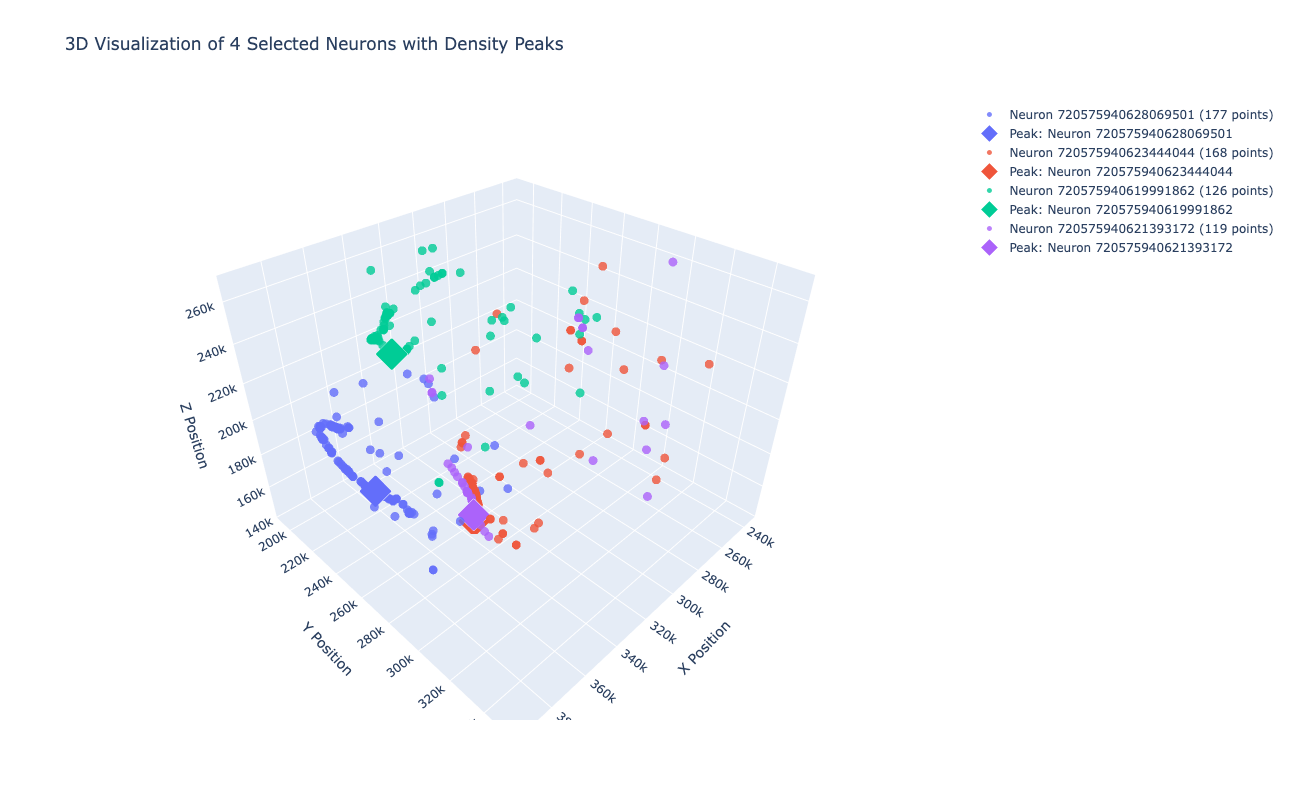

In [54]:
neurons_to_visualize = [
    720575940628069501,
    720575940623444044,
    720575940619991862,
    720575940621393172,
]

filtered_df = processed_coordinates[processed_coordinates["root_id"].isin(neurons_to_visualize)]
fig = go.Figure()
colors = px.colors.qualitative.Plotly[: len(neurons_to_visualize)]

for i, neuron_id in enumerate(neurons_to_visualize):
    neuron_data = filtered_df[filtered_df["root_id"] == neuron_id]

    if len(neuron_data) > 0:
        # Add scatter points for the neuron
        fig.add_trace(
            go.Scatter3d(
                x=neuron_data["position_x"],
                y=neuron_data["position_y"],
                z=neuron_data["position_z"],
                mode="markers",
                marker=dict(size=5, color=colors[i], opacity=0.8),
                name=f"Neuron {neuron_id} ({len(neuron_data)} points)",
            )
        )

        # Calculate and add density peak
        positions = neuron_data[["position_x", "position_y", "position_z"]].values

        if len(positions) > 10:
            # Use KDE for density peak
            kde = gaussian_kde(positions.T)
            densities = kde(positions.T)
            max_density_idx = np.argmax(densities)
            peak_x, peak_y, peak_z = positions[max_density_idx]
        else:
            # Use median for small datasets
            peak_x = np.median(positions[:, 0])
            peak_y = np.median(positions[:, 1])
            peak_z = np.median(positions[:, 2])

        # Add density peak marker
        fig.add_trace(
            go.Scatter3d(
                x=[peak_x],
                y=[peak_y],
                z=[peak_z],
                mode="markers",
                marker=dict(
                    size=15, color=colors[i], symbol="diamond", line=dict(color="white", width=2)
                ),
                name=f"Peak: Neuron {neuron_id}",
            )
        )

fig.update_layout(
    title="3D Visualization of 4 Selected Neurons with Density Peaks",
    scene=dict(
        xaxis_title="X Position",
        yaxis_title="Y Position",
        zaxis_title="Z Position",
        aspectmode="data",
    ),
    width=1100,
    height=800,
)
fig.show()

In [45]:
from collections import defaultdict


def parse_synapse_table(unzipped_file_path):
    pre_to_rows, post_to_rows = defaultdict(list), defaultdict(list)
    with open(unzipped_file_path, "r") as file:
        next(file)  # Skip header row
        pre_id, post_id = None, None
        for line in file:
            parts = line.strip().split(",")
            pre_id = int(parts[0]) if parts[0] else pre_id
            post_id = int(parts[1]) if parts[1] else post_id
            x, y, z = map(int, parts[2:5])
            row = [pre_id, post_id, x, y, z]
            pre_to_rows[pre_id].append(row)
            post_to_rows[post_id].append(row)
    return pre_to_rows, post_to_rows


pre_to_rows, post_to_rows = parse_synapse_table(os.path.join(data_dir, "synapse_coordinates.csv"))

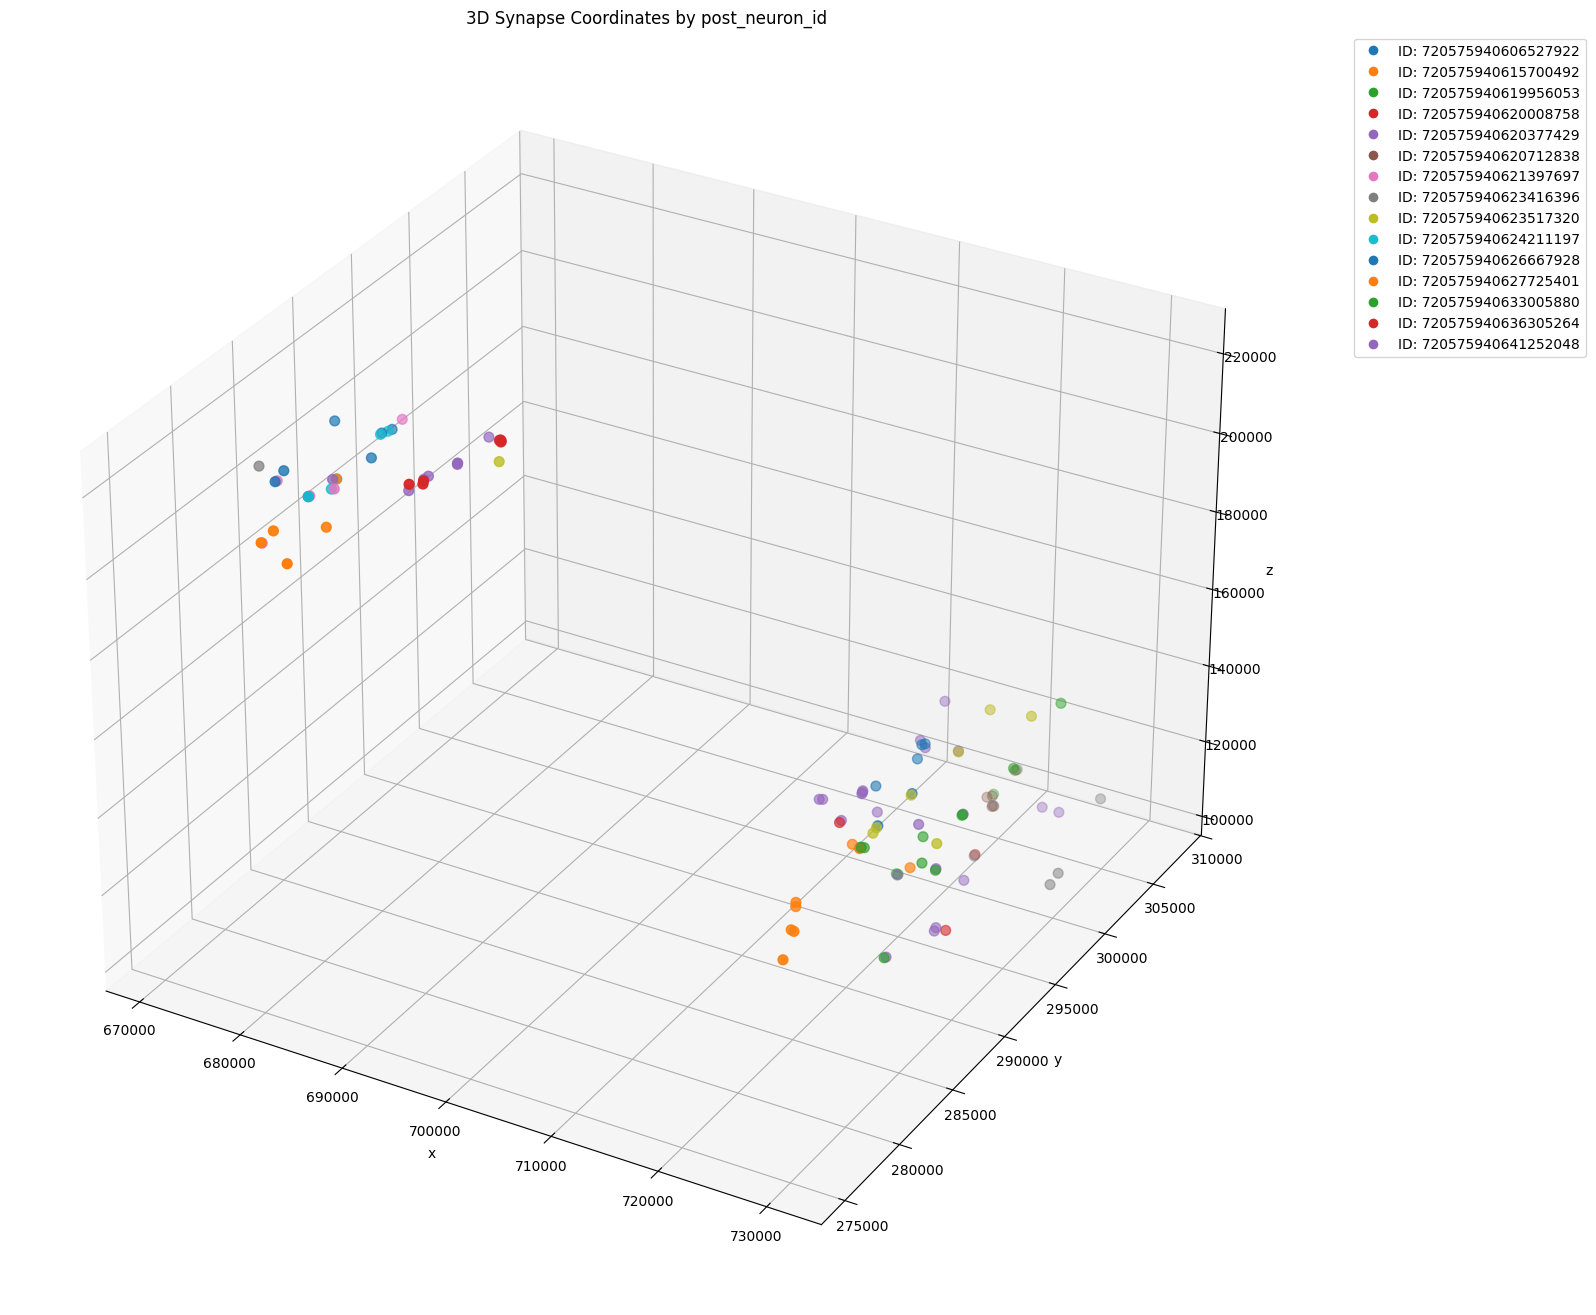

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

syn_coord1 = np.array(pre_to_rows[720575940598267657])

post_ids = syn_coord1[:, 1]
x = syn_coord1[:, 2]  # x
y = syn_coord1[:, 3]  # y
z = syn_coord1[:, 4]  # z

unique_post_ids = np.unique(post_ids)
n_colors = len(unique_post_ids)

colors_palette = sns.color_palette("tab10", n_colors)

color_map = {pid: colors_palette[idx] for idx, pid in enumerate(unique_post_ids)}
colors = [color_map[pid] for pid in post_ids]

# Plot
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(x, y, z, c=colors, s=50)
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color_map[pid],
        markersize=8,
        label=f"ID: {int(pid)}",
    )
    for pid in unique_post_ids
]
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.title("3D Synapse Coordinates by post_neuron_id")
plt.tight_layout()
plt.show()

Neuron 720575940597944841 (presynaptic): 102 synapses
Neuron 720575940597944841 (postsynaptic): 106 synapses


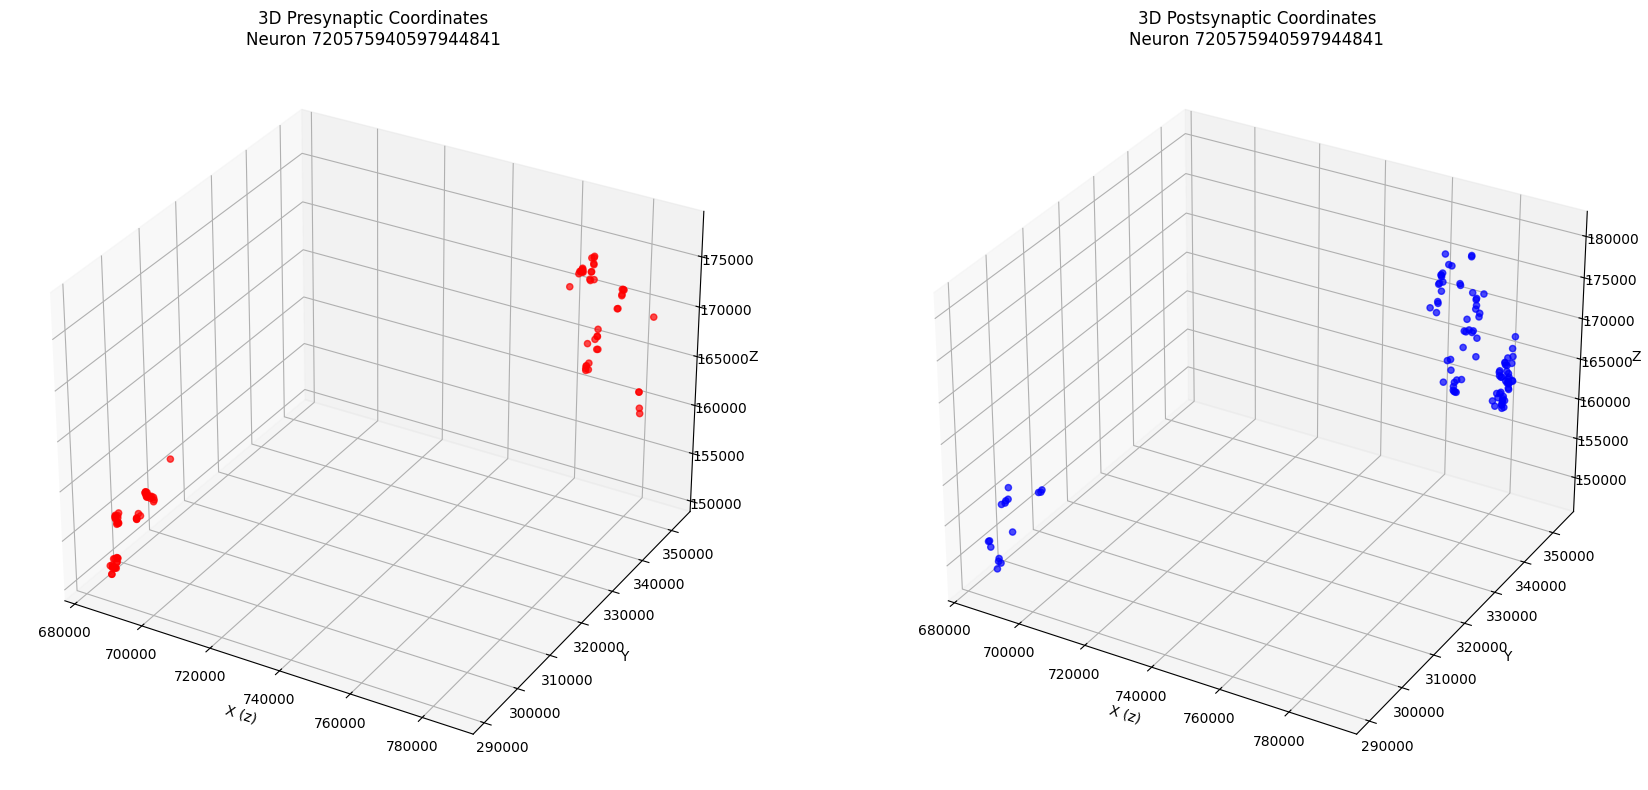

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_neuron_synapses(ax, neuron_id, synapse_data, synapse_type, color="blue"):
    synapse_rows = synapse_data[neuron_id]
    print(f"Neuron {neuron_id} ({synapse_type}): {len(synapse_rows)} synapses")
    synapses = np.array(synapse_rows)

    # Extract coordinates
    x = synapses[:, 2]  # X
    y = synapses[:, 3]  # Y
    z = synapses[:, 4]  # Z

    ax.scatter(x, y, z, alpha=0.7, color=color)
    ax.set_xlabel("X (z)")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"3D {synapse_type.capitalize()} Coordinates\nNeuron {neuron_id}")

# Select a neuron ID
neuron_id = 720575940597944841

# Create one figure with two 3D subplots in one row
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Plot presynaptic and postsynaptic
plot_neuron_synapses(ax1, neuron_id, pre_to_rows, "presynaptic", color="red")
plot_neuron_synapses(ax2, neuron_id, post_to_rows, "postsynaptic", color="blue")

plt.tight_layout()
plt.show()


In [48]:
print("=== SYNAPSE COUNT COMPARISON ===")
postsynaptic_count = df_connections[df_connections["post_root_id"] == neuron_id]["syn_count"].sum()
presynaptic_count = df_connections[df_connections["pre_root_id"] == neuron_id]["syn_count"].sum()

print(f"Neuron {neuron_id}:")
print(f"  Postsynaptic connections (inputs TO this neuron): {postsynaptic_count}")
print(f"  Presynaptic connections (outputs FROM this neuron): {presynaptic_count}")

=== SYNAPSE COUNT COMPARISON ===
Neuron 720575940597944841:
  Postsynaptic connections (inputs TO this neuron): 106
  Presynaptic connections (outputs FROM this neuron): 102


In [49]:
## OTHER CELL CLASSIFICATIONS
##

# df_classification
df_connectivity_tags["connectivity_tag"][0]

'3_cycle_participant,feedforward_loop_participant,rich_club'

- 3_cycle_participant: 68791
- feedforward_loop_participant: 118277
- rich_club: 41760
- reciprocal: 81245
- highly_reciprocal_neuron: 2440
- nsrn: 684
- integrator: 671
- broadcaster: 477


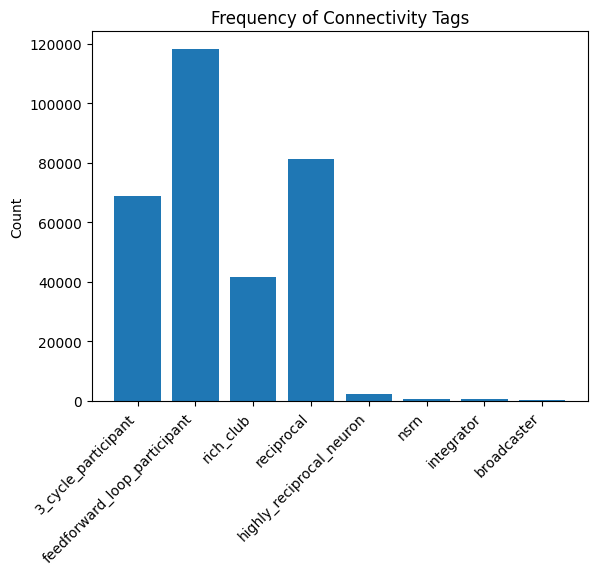

In [50]:
from collections import Counter
import matplotlib.pyplot as plt

# Example: list of tag strings
connectivity_tags = df_connectivity_tags["connectivity_tag"]

# Flatten and count
all_tags = [tag.strip() for line in connectivity_tags for tag in line.split(",")]
tag_counts = Counter(all_tags)

for t, c in tag_counts.items():
    print(f"- {t}: {c}")

# Plot
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xticks(rotation=45, ha="right")
plt.title("Frequency of Connectivity Tags")
plt.ylabel("Count")
plt.show()

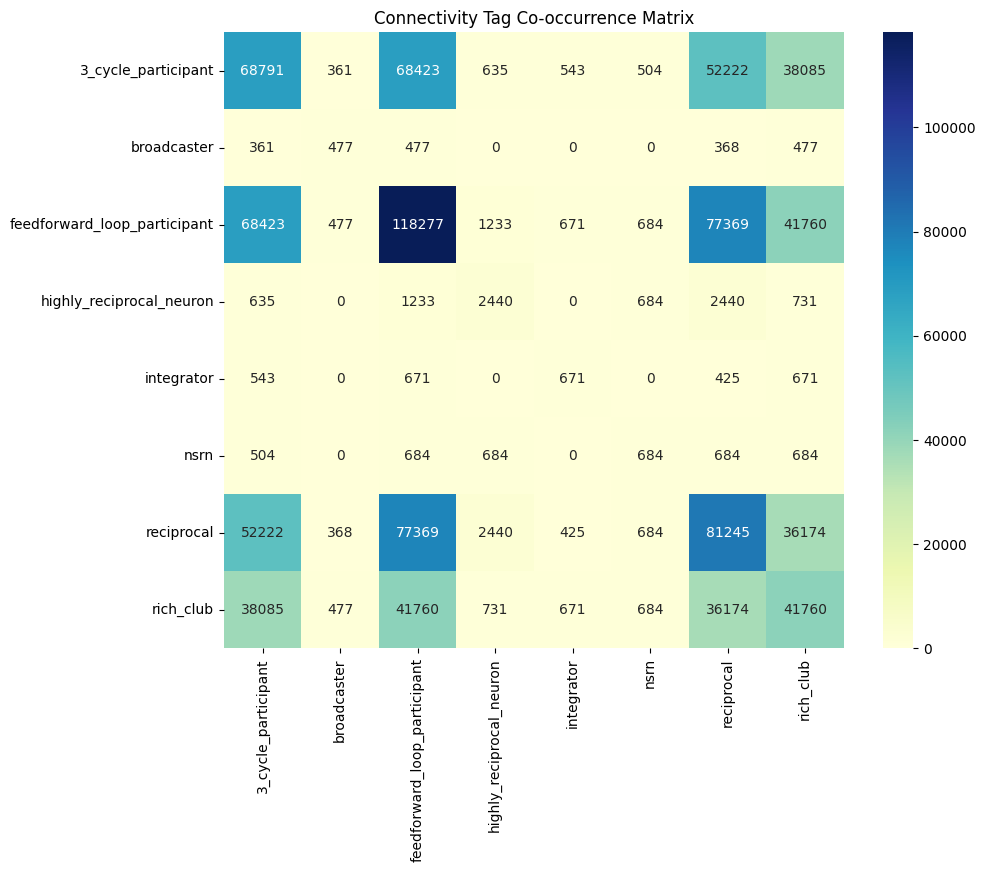

In [51]:
# Create binary matrix
unique_tags = sorted(set(all_tags))
data = []

for tag_str in connectivity_tags:
    tag_set = set(tag_str.split(","))
    data.append([1 if tag in tag_set else 0 for tag in unique_tags])

df = pd.DataFrame(data, columns=unique_tags)

# Co-occurrence matrix
co_matrix = df.T.dot(df)

# Plot
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Connectivity Tag Co-occurrence Matrix")
plt.show()

In [52]:
combo_counts = Counter([",".join(sorted(set(tags.split(",")))) for tags in connectivity_tags])

# Top 10 most common combinations
top_combos = combo_counts.most_common(10)
for combo, count in top_combos:
    print(f"{combo}: {count}")

3_cycle_participant,feedforward_loop_participant,reciprocal,rich_club: 32155
feedforward_loop_participant: 23709
feedforward_loop_participant,reciprocal: 22051
3_cycle_participant,feedforward_loop_participant,reciprocal: 18642
3_cycle_participant,feedforward_loop_participant: 11613
3_cycle_participant,feedforward_loop_participant,rich_club: 4480
reciprocal: 2516
feedforward_loop_participant,reciprocal,rich_club: 2495
highly_reciprocal_neuron,reciprocal: 1201
feedforward_loop_participant,rich_club: 751
